In [49]:
import cv2
from matplotlib import pyplot as plt 
from matplotlib.pyplot import figure

def show_img(img):
    plt.figure(figsize=(15,15))
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    plt.show()
    
def show_img_fn(fn):
    img = read_img(f'frames/{fn}.jpg')
    show_img(img)
    
def annotate(img, raw_x, raw_y, raw_width, raw_height):
    img_height, img_width, channels = img.shape
    center_x, center_y, width, height = raw_x * img_width, raw_y * img_height, raw_width * img_width, raw_height * img_height
    nw_x = int(center_x - width/2)
    nw_y = int(center_y - height/2)
    se_x = int(center_x + width/2)
    se_y = int(center_y + height/2)
    cv2.rectangle(img,(nw_x, nw_y),(se_x, se_y),(0,255,0),3)
    
def get_annotation(name, path = "ying-day2-annotations-3000/"):
    with open(f'{path}{name}.txt') as f:
        line = f.readline() # read one line
        _, raw_x, raw_y, raw_width, raw_height = [float(val) for val in line.split(' ')]

    # x, y are center of bounding box
    return raw_x, raw_y, raw_width, raw_height

def read_img(filename):
    return cv2.imread(filename)

def write_img(img, filename):
    cv2.imwrite(filename, img) 

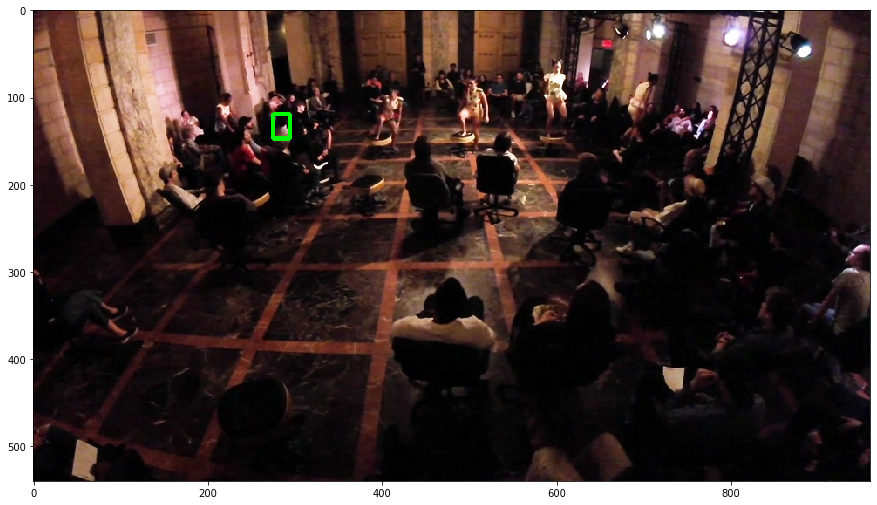

In [50]:
# show annotated image
frame = '2222_0'
img = read_img(f'smaller-frames/{frame}.jpg')
annotate(img, *get_annotation(frame, path = 'updated-annotations/'))
show_img(img)

In [51]:
import json
from collections import namedtuple
from itertools import chain

InferenceObject = namedtuple('InferenceObject', ['cx', 'cy', 'width', 'height', 'confidence'])
InferenceResult = namedtuple('InferenceResult', ['filename', 'number', 'objects', 'ground_truth'])

def num_from_name(name):
    """
    '0000_1.txt' -> 0.1
    '0000_1' -> 0.1
    """
    return float(name.split('.')[0].replace('_', '.'))

def get_inference_objects_from_ground_truth(filename, annotation_path):
    for line in open(filename):
        base_name = line.split('/')[-1].split('.')[0]
        if base_name: # filter out empty strings
            annotation = get_annotation(base_name, annotation_path)
            obj = InferenceObject(*annotation, 1.0)
            yield InferenceResult(f'{base_name}.jpg', num_from_name(base_name), [obj], True)
    
            
def get_inference_objects_from_results(result_filename):
    with open(result_filename) as file:
        s = file.read() # because of some encoding issue we need to do this two step process
        results = json.loads(s) 

        for r in results:
            objects = [InferenceObject(o['relative_coordinates']['center_x'], 
                                       o['relative_coordinates']['center_y'], 
                                       o['relative_coordinates']['width'], 
                                       o['relative_coordinates']['height'],
                                       o['confidence']) for o in r['objects']]
            name = r['filename'].split('/')[-1]
            try:
                num = num_from_name(name)
            except ValueError:
                continue
            
            yield InferenceResult(name, num, objects, False)

def save_images_with_annotations(results, output_dir):
    if type(results) is not list:
        results = [results] 
    
    for r in results:
        img = read_img(f'smaller-frames/{r.filename}')
        for o in r.objects:
            annotate(img, *o[0:4])
        write_img(img, f'{output_dir}/{r.filename}')

def show_inference(r):
    print(f'name:{r.filename}, confidence:{r.objects[0].confidence}')
    img = read_img(f'smaller-frames/{r.filename}')
    for o in r.objects:
        annotate(img, *o[0:4])
    show_img(img)

number of results 478 in range:0, 2500
name:1646_0.jpg, confidence:0.991902


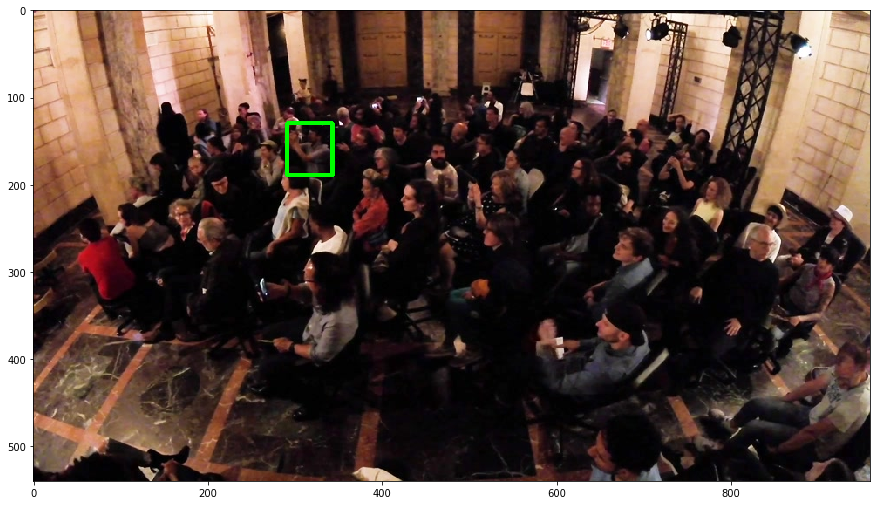

In [71]:
import random

path = '/Users/ying/code/personal-website/ecs-forying/results20201115/result_best.json'
path = '/Users/ying/code/personal-website/ecs-forying/results20201128/results_today/result_testing_20201128_best.json'

inference_objects = get_inference_objects_from_results(path)
res = [r for r in inference_objects if r.objects]
lower, upper = 0, 2500
res = [x for x in res if x.number in range(lower, upper)]
print(f'number of results {len(res)} in range:{lower}, {upper}')
r = random.choice(res)
show_inference(r)

In [72]:
from operator import attrgetter
def get_all_inference_objects():
    return sorted(
        list(
            chain(get_inference_objects_from_ground_truth('train.txt', annotation_path = 'updated-annotationsnov28/'),
                  get_inference_objects_from_ground_truth('test.txt', annotation_path = 'updated-annotationsnov28/'),
                  [r for r in get_inference_objects_from_results(path) if r.objects])
        ),
        key=attrgetter('number')
    )


In [73]:
from math import sqrt


def distance(inference_obj1, inference_obj2):
    return sqrt((inference_obj1.cx - inference_obj2.cx) ** 2 +
                (inference_obj1.cy - inference_obj2.cy) ** 2)

def interpolate(a, b, scale):
    a, b = b, a if a > b else None        
    return a + (b - a) * scale

def size(self):
    return self.width * self.height        
setattr(InferenceObject, 'size', size)

def scaled_square_px(y_px):
    """
    Returns the estimated distance in px of a square on the floor based on its y position

    At 540 px, one side of a square is 205 px in length, roughly.
    At 124 px, one side of a square is 48 px in length, roughly. 
    """
    slope = (205 - 48) / (540 - 124)
    square_length = (slope * (y_px - 540)) + 205 
    return square_length
    
def convert_px_to_m(distance_px, y_px):
    """
    Scales distance in pixels to distance in m, based on the y position of the distance occurring
    """
    m = 8.5/7
    return distance_px / scaled_square_px(y_px) * m


# some tests

print(f'y: 170 square: {scaled_square_px(170)}')

print(f'dist: 205, y: 540 actual: {convert_px_to_m(205, 540)}')
print(f'dist: 48, y: 124 actual: {convert_px_to_m(48, 124)}')
print(f'width = 2 and height = 2, size: {InferenceObject(0, 0, 2, 2, 1).size()}')
      

y: 170 square: 65.36057692307693
dist: 205, y: 540 actual: 1.2142857142857142
dist: 48, y: 124 actual: 1.2142857142857142
width = 2 and height = 2, size: 4


In [74]:
from statistics import mean
from operator import itemgetter


# If we jump more than 180px(roughly 0.2 * 960 ~= 180) between each second, then ignore result as false positive
max_velocity = 0.2 # pixels/s

def convert_to_actual_px(obj):
    width, height = 960, 540
    return obj._replace(
        cx=obj.cx * width,
        cy=obj.cy * height,
        width=obj.width * width,
        height=obj.height * height, 
    )

def convert_to_scaled_px(obj):
    width, height = 960, 540
    return obj._replace(
        cx=obj.cx / width,
        cy=obj.cy / height,
        width=obj.width / width,
        height=obj.height / height, 
    )


def convert_result_to_actual_px(res):
    convert = lambda obj: convert_to_actual_px(obj)
    res = res._replace(objects=list(map(convert, res.objects)))
    return res

def convert_result_to_scaled_px(res):
    convert = lambda obj: convert_to_scaled_px(obj)
    res = res._replace(objects=list(map(convert, res.objects)))
    return res

def find_next_object(last, next_result):
    min_dist, min_inference = 1000, None # tuple of min dist, inference obj
    for o in next_result.objects:
        dist = distance(o, last)
        if dist < min_dist:
            min_dist = dist
            min_inference = o
    return min_inference

def get_positions(all_objects):
    positions = []
    for r in all_objects:
        if len(r.objects) == 0: continue
        if len(positions) == 0:
            if len(r.objects) == 1:
                positions.append((r.objects[0], r.number))
                continue
            else:
                raise RuntimeError('found more than one object at start')

        last, _ = positions[-1]
        next_obj = find_next_object(last, r)
        if next_obj and next_obj.size() > 800.0: # anything smaller than 10px^2 is a mistake
            positions.append((next_obj, r.number))    
            
    return positions


def get_distances_between_positions(positions, threshold=True, real_distance=True):
    """
    Returns an array of tuples representing distances travelled between frames.
    Tuple format:
    (
        distance_in_meters,
        inference_object_for_current_frame,
        timestamp_for_current_frame_s, 
        timestamp_for_prev_frame_s
    )
    """
    distances = []
    for fore, aft in zip(positions, positions[1:]):
        fore_obj, _ = fore
        aft_obj, _ = aft
        
#         # get the y position, and based on that, scale the distance linearly.
        mean_y = mean([fore_obj.cy, aft_obj.cy])
    
        # any movement under this threshold is discarded as jitter.
        # unit: fraction of a square. ie, closer to the camera, jitter has a higher threshold
        movement_min = 0.05
        movement_max = 0.3
        
        d = distance(fore_obj, aft_obj)
        if threshold:
            square = scaled_square_px(mean_y)
            d = d if  square * movement_min < d < square * movement_max else 0
        
        if real_distance:
            d = convert_px_to_m(d, mean_y)
        
        distances.append((d, aft[0], aft[1], fore[1]))
    return distances

def stillness_ranges(distances):
    """
    Returns an array of tuples representing periods of stillness that Jeff has during
    the performance. Tuple format is (start_offset_in_s, end_offset_in_s, length_s)
    """
    stillness = []
    stillness_start = None
    for dist, obj, num, _ in distances:
        if stillness_start == None:
            stillness_start = num

        if dist == 0:
            continue
        else:
            stillness.append((stillness_start, num, num - stillness_start))
            stillness_start = None
    return stillness

def get_speeds(distances):
    """
    Returns an array of tuples representing instantaneous speed between frames
    Tuple format:
    (
        speed_in_m_per_s,
        timestamp_s
    )
    """     
    return [(dist / (num - prev_num), num) for dist, _, num, prev_num in distances]
    


# have to convert before doing any analysis, because euclidian distance on fractionals
# don't work
all_objects = get_all_inference_objects()

# our annotation is a little sloppy in these areas, we exclude these frames
nums_to_filter = set([411.2, 411.6, 412.0 ,412.4, 412.8, 413.2, 413.6, 414, 414.4, 414.8, 415.2, 415.6, 416.0, 416.4, 416.8, 417.2, 417.6, 418, 418.4, 418.8, 419.2, 419.6, 420, 420.4, 420.8, 421.2, 421.6, 422.2, 422.4, 422.8])
all_objects = [o for o in all_objects if o.number not in nums_to_filter]
all_objects = [convert_result_to_actual_px(o) for o in all_objects]
positions = get_positions(all_objects)
distances = get_distances_between_positions(positions)
speeds = get_speeds(distances)
stillnesses = stillness_ranges(distances)

In [75]:
len(all_objects)

5672

In [76]:
save_images_with_annotations([convert_result_to_scaled_px(x) for x in all_objects], 'nov-frames')

KeyboardInterrupt: 

In [67]:
from operator import itemgetter
# old code 20201115
print(f'sum: {sum(x[0] for x in distances)}')
print(f'max: {max(distances, key=lambda x: x[0])}')
print(f'max stillness: {max(stillnesses, key=lambda x: x[2])}')
print(f'max speed: {max(speeds, key=lambda x: x[0])}')
              

sum: 73.16692801403154
max: (0.3526827488860354, InferenceObject(cx=311.57664, cy=150.40404, width=32.6256, height=55.114020000000004, confidence=0.57359), 2085.6, 2082.8)
max stillness: (708.0, 797.2, 89.20000000000005)
max speed: (0.8529069737476529, 2266.8)


In [96]:
print('Distance travelled: {:.2f}m'.format(sum(x[0] for x in distances)))
print('Longest time in stillness: {:.2f}s '.format(max(stillnesses, key=lambda x: x[2])[2]))
print('Maximum speed: {:.2f}m/s'.format(max(speeds, key=lambda x: x[0])[0]))

Distance travelled: 73.17m
Longest time in stillness: 89.20s 
Maximum speed: 0.85m/s


In [82]:


longest_distances = sorted(distances, key=lambda x: x[0], reverse=True)[:15]
print(longest_distances)
longest_distances = sorted(longest_distances, key=lambda x: x[2])

longest = iter(longest_distances)
_, _, cur, _ = next(longest)
arr = []
delta = 1
for o in all_objects:
    if cur - delta < o.number < cur + delta: 
        arr.append(o)
    if o.number > cur + delta:
        try:
            _, _, cur, _ = next(longest)
        except StopIteration:
            break
            
nums = set([o.number for o in arr])

# [(n,o) for _, o, n in longest_distances]

results = [convert_result_to_scaled_px(x) for x in arr if x.number in nums]
save_images_with_annotations(results, 'longest-outputs')
# show_inference(longest_results[0])
# longest_results[0]


[(0.3526827488860354, InferenceObject(cx=311.57664, cy=150.40404, width=32.6256, height=55.114020000000004, confidence=0.57359), 2085.6, 2082.8), (0.34116278949913875, InferenceObject(cx=297.7392, cy=136.79981999999998, width=38.460480000000004, height=50.425200000000004, confidence=0.335727), 2266.8, 2266.4), (0.3405896712032474, InferenceObject(cx=366.0, cy=140.24988000000002, width=22.00032, height=45.49986, confidence=1.0), 456.8, 450.8), (0.33850804695362036, InferenceObject(cx=375.2496, cy=151.25021999999998, width=33.50016, height=78.4998, confidence=1.0), 423.2, 410.8), (0.3326787163689884, InferenceObject(cx=293.50464, cy=146.08782000000002, width=37.93824, height=54.3753, confidence=0.690218), 2156.0, 2155.2), (0.32405394404740906, InferenceObject(cx=372.2496, cy=245.50019999999998, width=75.50016, height=117.00018, confidence=1.0), 222.4, 222.0), (0.32167228337163023, InferenceObject(cx=334.24992000000003, cy=178.50024000000002, width=59.49984, height=65.99988, confidence=1.

reading smaller-frames/1958_0.jpg
annotating with InferenceObject(cx=0.371819, cy=0.299055, width=0.044095, height=0.104762, confidence=0.250891)
writing longest-outputs/1958_0.jpg
reading smaller-frames/1958_8.jpg
annotating with InferenceObject(cx=0.383266, cy=0.282625, width=0.049675, height=0.09882, confidence=0.979192)
writing longest-outputs/1958_8.jpg
reading smaller-frames/1959_2.jpg
annotating with InferenceObject(cx=0.386029, cy=0.281976, width=0.048618, height=0.090899, confidence=0.918653)
writing longest-outputs/1959_2.jpg
reading smaller-frames/1959_6.jpg
annotating with InferenceObject(cx=0.383809, cy=0.299195, width=0.044490999999999996, height=0.131192, confidence=0.982204)
writing longest-outputs/1959_6.jpg
reading smaller-frames/2085_6.jpg
annotating with InferenceObject(cx=0.324559, cy=0.278526, width=0.033985, height=0.102063, confidence=0.57359)
writing longest-outputs/2085_6.jpg
reading smaller-frames/2086_0.jpg
annotating with InferenceObject(cx=0.334907, cy=0.2

In [25]:
# print(f'sum: {[x for x in distances]}')
[(x, i) for i,x in enumerate(distances) if x[2] > 1977]

[((0.0, 1977.2), 4711),
 ((0.041915110578791596, 1977.6), 4712),
 ((0.05376426709960382, 1978.0), 4713),
 ((0.014894901047249838, 1978.4), 4714),
 ((0.01585535028548351, 1978.8), 4715),
 ((0.02171658431542903, 1979.2), 4716),
 ((0.0, 1979.6), 4717),
 ((0.03976377005417227, 1980.0), 4718),
 ((0.018733352123268193, 1980.4), 4719),
 ((0.029597982593589922, 1980.8), 4720),
 ((1.6675653000019783, 1981.2), 4721),
 ((1.6342152602738012, 1981.6), 4722),
 ((0.013964575537559141, 1982.4), 4723),
 ((0.11950419060481199, 1983.6), 4724),
 ((0.01729280824274964, 1984.0), 4725),
 ((0.017237243746267658, 1984.4), 4726),
 ((0.12043645589667713, 1984.8), 4727),
 ((0.035435822858673395, 1985.2), 4728),
 ((0.12940138140712076, 1985.6), 4729),
 ((0.0501977769952864, 1986.0), 4730),
 ((0.014936736183094868, 1986.4), 4731),
 ((0.052142385733570364, 1986.8), 4732),
 ((0.03932289905233757, 1987.2), 4733),
 ((0.11265039771098863, 1988.4), 4734),
 ((0.270463631822369, 1988.8), 4735),
 ((0.016949348375209658, 198

In [93]:
more_than_one = [convert_result_to_scaled_px(x) for x in all_objects if len(x.objects) > 1]
save_images_with_annotations(more_than_one, 'more-than-one-outputs')
len(more_than_one)
        

reading smaller-frames/1283_2.jpg
annotating with InferenceObject(cx=0.284889, cy=0.372743, width=0.066671, height=0.174452, confidence=0.987316)
annotating with InferenceObject(cx=0.455313, cy=0.267273, width=0.049316, height=0.16551, confidence=0.339386)
writing more-than-one-outputs/1283_2.jpg
reading smaller-frames/1322_4.jpg
annotating with InferenceObject(cx=0.332833, cy=0.312265, width=0.044414, height=0.129695, confidence=0.943817)
annotating with InferenceObject(cx=0.116555, cy=0.81615, width=0.155006, height=0.340567, confidence=0.593528)
writing more-than-one-outputs/1322_4.jpg
reading smaller-frames/1360_8.jpg
annotating with InferenceObject(cx=0.353179, cy=0.283508, width=0.04526299999999999, height=0.108931, confidence=0.959104)
annotating with InferenceObject(cx=0.121148, cy=0.426381, width=0.042554, height=0.146366, confidence=0.460089)
writing more-than-one-outputs/1360_8.jpg
reading smaller-frames/1464_4.jpg
annotating with InferenceObject(cx=0.3651670000000001, cy=0.

reading smaller-frames/1763_6.jpg
annotating with InferenceObject(cx=0.918688, cy=0.769281, width=0.123079, height=0.27504, confidence=0.900451)
annotating with InferenceObject(cx=0.336578, cy=0.302238, width=0.03576, height=0.109719, confidence=0.648845)
writing more-than-one-outputs/1763_6.jpg
reading smaller-frames/1764_0.jpg
annotating with InferenceObject(cx=0.334587, cy=0.300853, width=0.038433, height=0.1042, confidence=0.910251)
annotating with InferenceObject(cx=0.910973, cy=0.778696, width=0.143528, height=0.306007, confidence=0.475708)
writing more-than-one-outputs/1764_0.jpg
reading smaller-frames/1769_6.jpg
annotating with InferenceObject(cx=0.912578, cy=0.777846, width=0.13702700000000004, height=0.304404, confidence=0.774266)
annotating with InferenceObject(cx=0.344061, cy=0.302442, width=0.035073, height=0.086062, confidence=0.344954)
writing more-than-one-outputs/1769_6.jpg
reading smaller-frames/1770_0.jpg
annotating with InferenceObject(cx=0.916406, cy=0.772479, widt

reading smaller-frames/1783_2.jpg
annotating with InferenceObject(cx=0.344415, cy=0.308349, width=0.044812, height=0.095037, confidence=0.87926)
annotating with InferenceObject(cx=0.9145799999999998, cy=0.800597, width=0.143437, height=0.340691, confidence=0.694252)
writing more-than-one-outputs/1783_2.jpg
reading smaller-frames/1783_6.jpg
annotating with InferenceObject(cx=0.344329, cy=0.306723, width=0.04471, height=0.096258, confidence=0.855394)
annotating with InferenceObject(cx=0.914533, cy=0.811634, width=0.129625, height=0.363494, confidence=0.683809)
writing more-than-one-outputs/1783_6.jpg
reading smaller-frames/1784_0.jpg
annotating with InferenceObject(cx=0.918083, cy=0.805538, width=0.150542, height=0.356829, confidence=0.809617)
annotating with InferenceObject(cx=0.33998, cy=0.306404, width=0.041662, height=0.104539, confidence=0.489108)
writing more-than-one-outputs/1784_0.jpg
reading smaller-frames/1784_4.jpg
annotating with InferenceObject(cx=0.339673, cy=0.305177, widt

reading smaller-frames/1965_6.jpg
annotating with InferenceObject(cx=0.400075, cy=0.282181, width=0.037101, height=0.133632, confidence=0.874178)
annotating with InferenceObject(cx=0.32439200000000007, cy=0.272321, width=0.032681, height=0.113158, confidence=0.517241)
writing more-than-one-outputs/1965_6.jpg
reading smaller-frames/1966_0.jpg
annotating with InferenceObject(cx=0.401984, cy=0.294743, width=0.039979, height=0.169809, confidence=0.802523)
annotating with InferenceObject(cx=0.322448, cy=0.271713, width=0.0332, height=0.106665, confidence=0.799156)
writing more-than-one-outputs/1966_0.jpg
reading smaller-frames/1967_2.jpg
annotating with InferenceObject(cx=0.401376, cy=0.281885, width=0.036901, height=0.134622, confidence=0.944425)
annotating with InferenceObject(cx=0.33164199999999994, cy=0.26963, width=0.035037, height=0.11939299999999999, confidence=0.387743)
writing more-than-one-outputs/1967_2.jpg
reading smaller-frames/1967_6.jpg
annotating with InferenceObject(cx=0.40

102

In [26]:
a = iter([1,2])
next(a)
next(a)
next(a)

StopIteration: 

In [70]:
[o for o in all_objects if 2044 < o.number < 2181]

[InferenceResult(filename='2044_4.jpg', number=2044.4, objects=[InferenceObject(cx=335.44991999999996, cy=148.56912, width=42.58368, height=88.31106, confidence=0.75177)], ground_truth=False),
 InferenceResult(filename='2180_0.jpg', number=2180.0, objects=[InferenceObject(cx=301.50048, cy=131.00022, width=25.999679999999998, height=38.99988, confidence=1.0)], ground_truth=True),
 InferenceResult(filename='2180_4.jpg', number=2180.4, objects=[InferenceObject(cx=300.50016, cy=130.50018, width=28.00032, height=37.9998, confidence=1.0)], ground_truth=True),
 InferenceResult(filename='2180_8.jpg', number=2180.8, objects=[InferenceObject(cx=300.50016, cy=130.50018, width=28.00032, height=37.9998, confidence=1.0)], ground_truth=True)]

In [96]:
def gaps_in_data(all_objects):
    """
    Returns an array of tuples representing periods of stillness that Jeff has during
    the performance. Tuple format is (start_offset_in_s, end_offset_in_s, length_s)
    """
    gaps = []
    start = None
    for prev, cur in zip(all_objects, all_objects[1:]):
        if cur.number - prev.number > 3:
            if start is None:
                start = prev.number
        else:
            if start is not None:
                gaps.append((start, prev.number))
                start = None
    return gaps

gaps_in_data(all_objects)

[(410.8, 422.0),
 (1545.6, 1549.6),
 (1595.6, 1608.8),
 (1816.0, 1830.4),
 (1906.4, 1928.0),
 (2008.4, 2011.6),
 (2014.4, 2026.8),
 (2047.2, 2052.4),
 (2052.8, 2091.2),
 (2094.0, 2159.6),
 (2162.8, 2204.0),
 (2206.0, 2211.2),
 (2213.2, 2237.2),
 (2240.8, 2339.6)]

In [47]:
import numpy as np
inputs = np.zeros(shape=(1, 4))
inputs[0][0] = 1
weights = np.ones((4,2))
outputs = np.ones((2,2))
a = inputs.dot(weights) # 1,3

print('input * weight', a)

print('input * weight * output\n', a.dot(outputs))


input * weight [[1. 1.]]
input * weight * output
 [[2. 2.]]
